<a href="https://colab.research.google.com/github/pranshuprasun/FreeCodeCamp/blob/master/Copy_of_Techincal_Analysis_(Event_Data)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Techincal Match Analysis

In this notebook, we are going to explore the passing style of the England Women's National Team in their World Cup final match with the USA

We will start by loading event data from StatsBomb, one of the main providers of event-based data across the top football leagues. 

We will then explore the positions that passes are played and received using Density Plots. 

After that, we will explore pass clusters to identify common locations passes are played and investigate if any patterns are emerging. 

Lastly, we will explore passing networks to identify who are the key players involved in the movement of the ball through various areas of the pitch. 

<img src='https://upload.wikimedia.org/wikipedia/en/thumb/3/38/England_crest_2009.svg/1200px-England_crest_2009.svg.png' width="400" hight="400" class="center">

In [ ]:
#@title
!pip install mplsoccer &> /dev/null
!pip install git+https://github.com/devinpleuler/analytics-handbook.git &> /dev/null

In [ ]:
#@title
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer import VerticalPitch, add_image, FontManager, Pitch
from sklearn.cluster import KMeans
from mplsoccer.statsbomb import read_event, EVENT_SLUG
from soccerutils.statsbomb import get_events
from soccerutils.pitch import Pitch as pitch_pass


Let's start by loading in some data from the StatsBomb GitHub repo, we will make this simpler by declaring the URL as a variable.

In [ ]:
# Read in data from StatsBomb Github
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"

Now let's make a function to help up parse the data based on our choice of match, event, team, etc. 

In [ ]:
# Create a function to parse out raw data for specific events

def parse_data(competition_id, season_id, match_id, event, team):
    matches = requests.get(url=comp_url.format(competition_id, season_id)).json()
    match_ids = [m['match_id'] for m in matches]

    all_events = []
    for match_ in tqdm(match_ids):
        if match_ == match_id:
          events = requests.get(url=match_url.format(match_id)).json()

          passes = [x for x in events if (x['type']['name'] == event) & (x['possession_team']['name'] == team)]
                
          for p in passes:
              attributes = {
                  "x": p['location'][0],
                  "y": p['location'][1],
                  "end_x": p['pass']['end_location'][0],
                  "end_y": p['pass']['end_location'][1],
                  "outcome": 0 if 'outcome' in p['pass'].keys() else 1,
              }
              all_events.append(attributes)
            
    return pd.DataFrame(all_events)

We will define our competition and season id for the world cup and our match id as the final game. We can then pass our event in and the team as strings.

In [ ]:
# Get data
comp_id = 72
seas_id = 30
match_id = 69258 
event_id = "Pass"
team_id = "England Women's"

df_pass = parse_data(competition_id=comp_id, season_id=seas_id, match_id=match_id, event=event_id, team=team_id)

100%|██████████| 52/52 [00:00<00:00, 101.37it/s]


**For reference we can pass in any of the following unique events:**

['Half End',
 'Miscontrol',
 'Foul Committed',
 'Half Start',
 'Pass',
 'Interception',
 'Shot',
 'Clearance',
 'Pressure',
 'Dribbled Past',
 'Substitution',
 'Dispossessed',
 'Ball Recovery',
 'Block',
 'Player Off',
 'Duel',
 'Goal Keeper',
 'Starting XI',
 'Carry',
 'Player On',
 'Injury Stoppage',
 'Ball Receipt*',
 'Foul Won',
 'Referee Ball-Drop',
 'Dribble',
 'Tactical Shift']

We can also modify our parse data function to extract any of the following attributes for an event:

['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type',
       'possession', 'possession_team', 'play_pattern', 'team', 'duration',
       'tactics', 'related_events', 'player', 'position', 'location', 'pass',
       'carry', 'ball_receipt', 'under_pressure', 'duel', 'counterpress',
       'interception', 'dribble', 'clearance', 'shot', 'goalkeeper',
       'off_camera', 'foul_won', 'ball_recovery', 'block', 'out',
       'foul_committed', 'injury_stoppage', 'substitution', 'miscontrol']

Now that we have our pass data stored in a dataframe, we can see the following attributes: 

x - x coordinate of the pass being played \\
y - x coordinate of the pass being played \\
end_x - x coordinate of the pass being received \\
end_y - y coordinate of the pass being received \\
outcome - successful or unsuccessful pass

In [ ]:
# Pass dataframe
df_pass

,x,y,end_x,end_y,outcome
0,60.0,40.0,33.4,56.9,1
1,33.7,62.9,76.9,55.7,0
2,44.1,25.3,48.7,12.3,1
3,47.5,11.3,64.3,42.1,0
4,55.5,42.1,38.8,35.8,1
...,...,...,...,...,...
522,79.3,64.9,71.8,67.8,1
523,74.1,67.3,69.9,53.5,1
524,64.4,8.4,47.0,14.2,1
525,47.5,14.2,92.4,56.7,0


Now that we have a dataframe with the location values of passes we can use it to understand how they are distributed in different areas of the pitch using a kernel density plot.

In [ ]:
# Define a color map
flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 100 colors",
                                                  ['#fafbfc', '#428df5'], N=100)

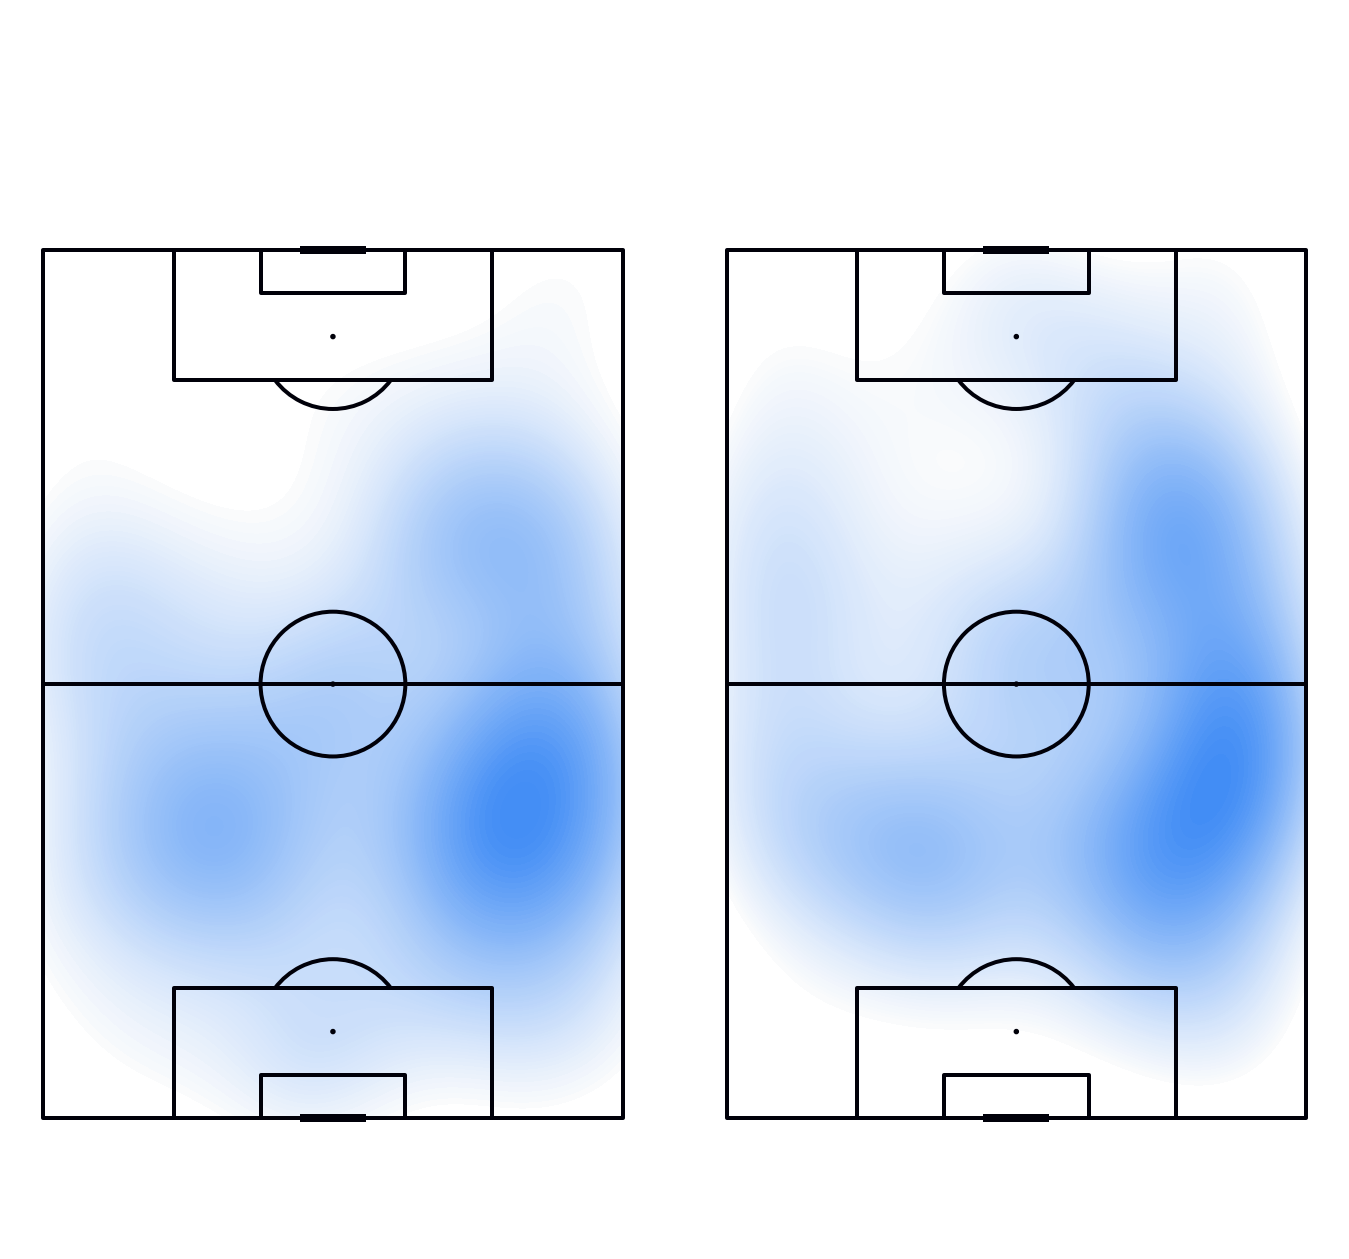

In [ ]:
# KDE Plots
pitch = VerticalPitch(line_color='#000009', line_zorder=2)

fig, axs = pitch.grid(ncols=2, axis=False)

# Pass played
pass_given = pitch.kdeplot(df_pass.x, df_pass.y, ax=axs['pitch'][0],
                           shade=True, levels=100, shade_lowest=False,
                           cut=4, cmap=flamingo_cmap)
# Pass received 
pass_recieved = pitch.kdeplot(df_pass.end_x, df_pass.end_y, ax=axs['pitch'][1],
                          shade=True, levels=100, shade_lowest=False,
                          cut=4, cmap=flamingo_cmap)


We can see from these plots that the England team tend to play more balls through the wings indicated by the darker shading as opposed to through the middle of the pitch. Along with a slight majority of balls being down the right side.   Let's investigate this further by clustering passes together and plotting the average location of those clusters.  

## Pass Clusters

We declare a KMeans model and fit it to our data.  

In [ ]:
# Pass Cluster Analysis
model = KMeans(n_clusters=20)

In [ ]:
# Fit a model
features = df_pass[['x', 'y', 'end_x', 'end_y']]
fit = model.fit(features)

In [ ]:
df_pass['cluster'] = model.predict(features)
df_pass.head(10)

,x,y,end_x,end_y,outcome,cluster
0,60.0,40.0,33.4,56.9,1,12
1,33.7,62.9,76.9,55.7,0,14
2,44.1,25.3,48.7,12.3,1,16
3,47.5,11.3,64.3,42.1,0,9
4,55.5,42.1,38.8,35.8,1,7
5,38.0,37.8,34.0,62.6,1,12
6,36.6,64.2,78.7,60.2,1,14
7,71.5,71.6,40.8,70.5,1,2
8,40.8,70.5,48.8,73.3,1,17
9,57.9,66.0,34.3,62.6,1,2


We assign each pass to a cluster and extract the centroids of those clusters. 

In [ ]:
# Compute centroids
centroids_ = pd.DataFrame(data = model.cluster_centers_, 
                           columns = ['start_x', 'start_y', 'end_x', 'end_y'])

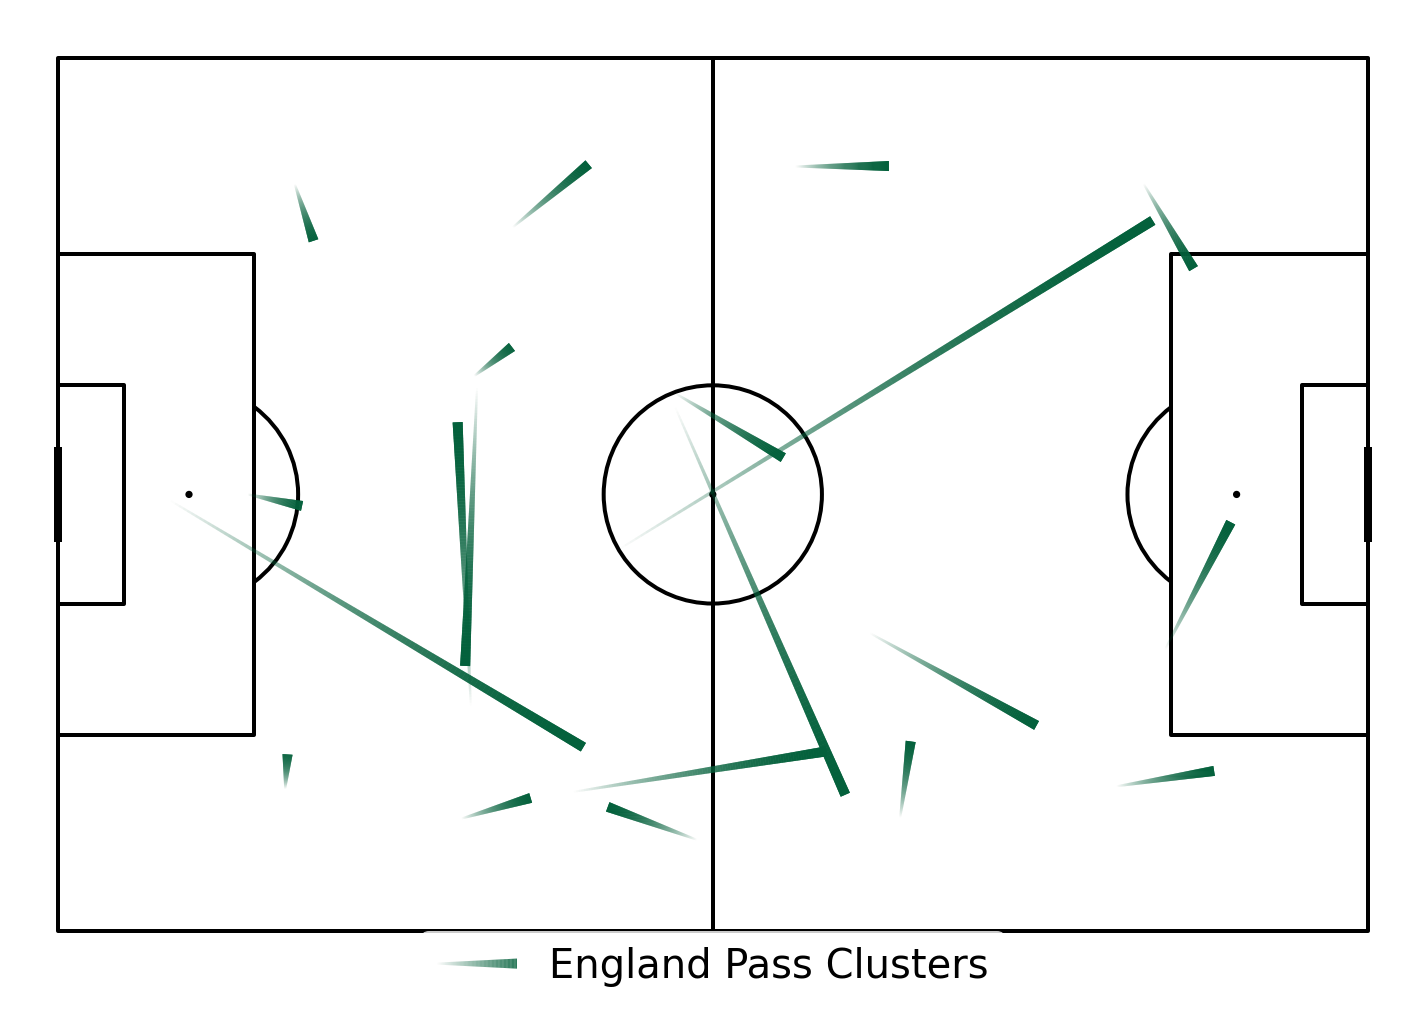

In [ ]:
# Plot pass clusters
pitch = Pitch(pitch_type='statsbomb', orientation='vertical',
              pitch_color='white', line_color='k',
              constrained_layout=False, tight_layout=False)

fig, ax = pitch.draw(figsize=(10, 8))

lc1 = pitch.lines(centroids_['start_x'], centroids_['start_y'],
                  centroids_['end_x'], centroids_['end_y'],
                  lw=5, transparent=True, comet=True, label='England Pass Clusters',
                  color='#04613c', ax=ax)
# Plot the legend
ax.legend(edgecolor='None', fontsize=20, loc='lower center', bbox_to_anchor=(0.5, -0.05))
plt.show()

We can see that England tend to play passes diagonally across the pitch with a sparsity of clusters in the middle of the pitch, and a high number of clusters on the right side as compared to the left. Finally, let's look at the key players in England's passing system and see how the ball is moved across the different areas/ zones of the pitch. 

## Passing Network

We start by pulling in the raw data again using a library developed by Devin Pleuler which will make the construction of pass networks simpler. 

In [ ]:
## Pass Network
raw_events = get_events(match_id=match_id)
lineups = raw_events[0:2]
team_lineup = lineups[1] # Modulate the 1 between [0,1] for [home,away]
team_id = team_lineup['team']['id']

In [ ]:
# Get starting players
starters = {p['player']['id']: {"name": p['player']['name'],
                                "jersey": p['jersey_number']} for p in team_lineup['tactics']['lineup']}

In [ ]:
# Extract events
events = [e for e in raw_events if e['team']['id'] == team_id]
passes = [e for e in raw_events if 'pass' in e.keys()]

Now we generate a matrix using a nested dictionary object of the general form matrix[player_a][player_b][passes]

In [ ]:
# Create a matrix of passes between players 
matrix = {}
for p in passes:
    if 'outcome' not in p['pass'].keys():
        passer_id = p['player']['id']
        recipient_id = p['pass']['recipient']['id']
        
        a, b = sorted([passer_id, recipient_id]) # <-- Note
        
        if a not in matrix.keys():
            matrix[a] = {}
            
        if b not in matrix[a].keys():
            matrix[a][b] = 0
            
        matrix[a][b] += 1  

We then create a dictionary of event locations for each player and extract the average position of those players. 

In [ ]:
# Get average pass locations 
positions = {}
for e in events:
    
    if 'player' in e.keys():
        player_id = e['player']['id']
        if player_id not in positions.keys():
            positions[player_id] = {"x":[], "y":[]}
            
        if 'location' in e.keys():
            positions[player_id]['x'].append(e['location'][0])
            positions[player_id]['y'].append(80-e['location'][1])
            
avg_positions = {k:[np.mean(v['x']),np.mean(v['y'])] for k, v in positions.items() if k in starters.keys()}

Now we build the edges of the matrix by looping over our passing network and computing the edge weights, which is the volume of passes exchanged between players.

In [ ]:
# Compute edges between players
lines = []
weights = []
for k, v in matrix.items():
    if k in starters.keys():
        origin = avg_positions[k]
        for k_, v_ in matrix[k].items():
            if k_ in starters.keys():
                dest = avg_positions[k_]
                lines.append([*origin, *dest])
                weights.append(v_)

Now we plot our passing network, with a minimum edge value of 2 passes between a set of players.  

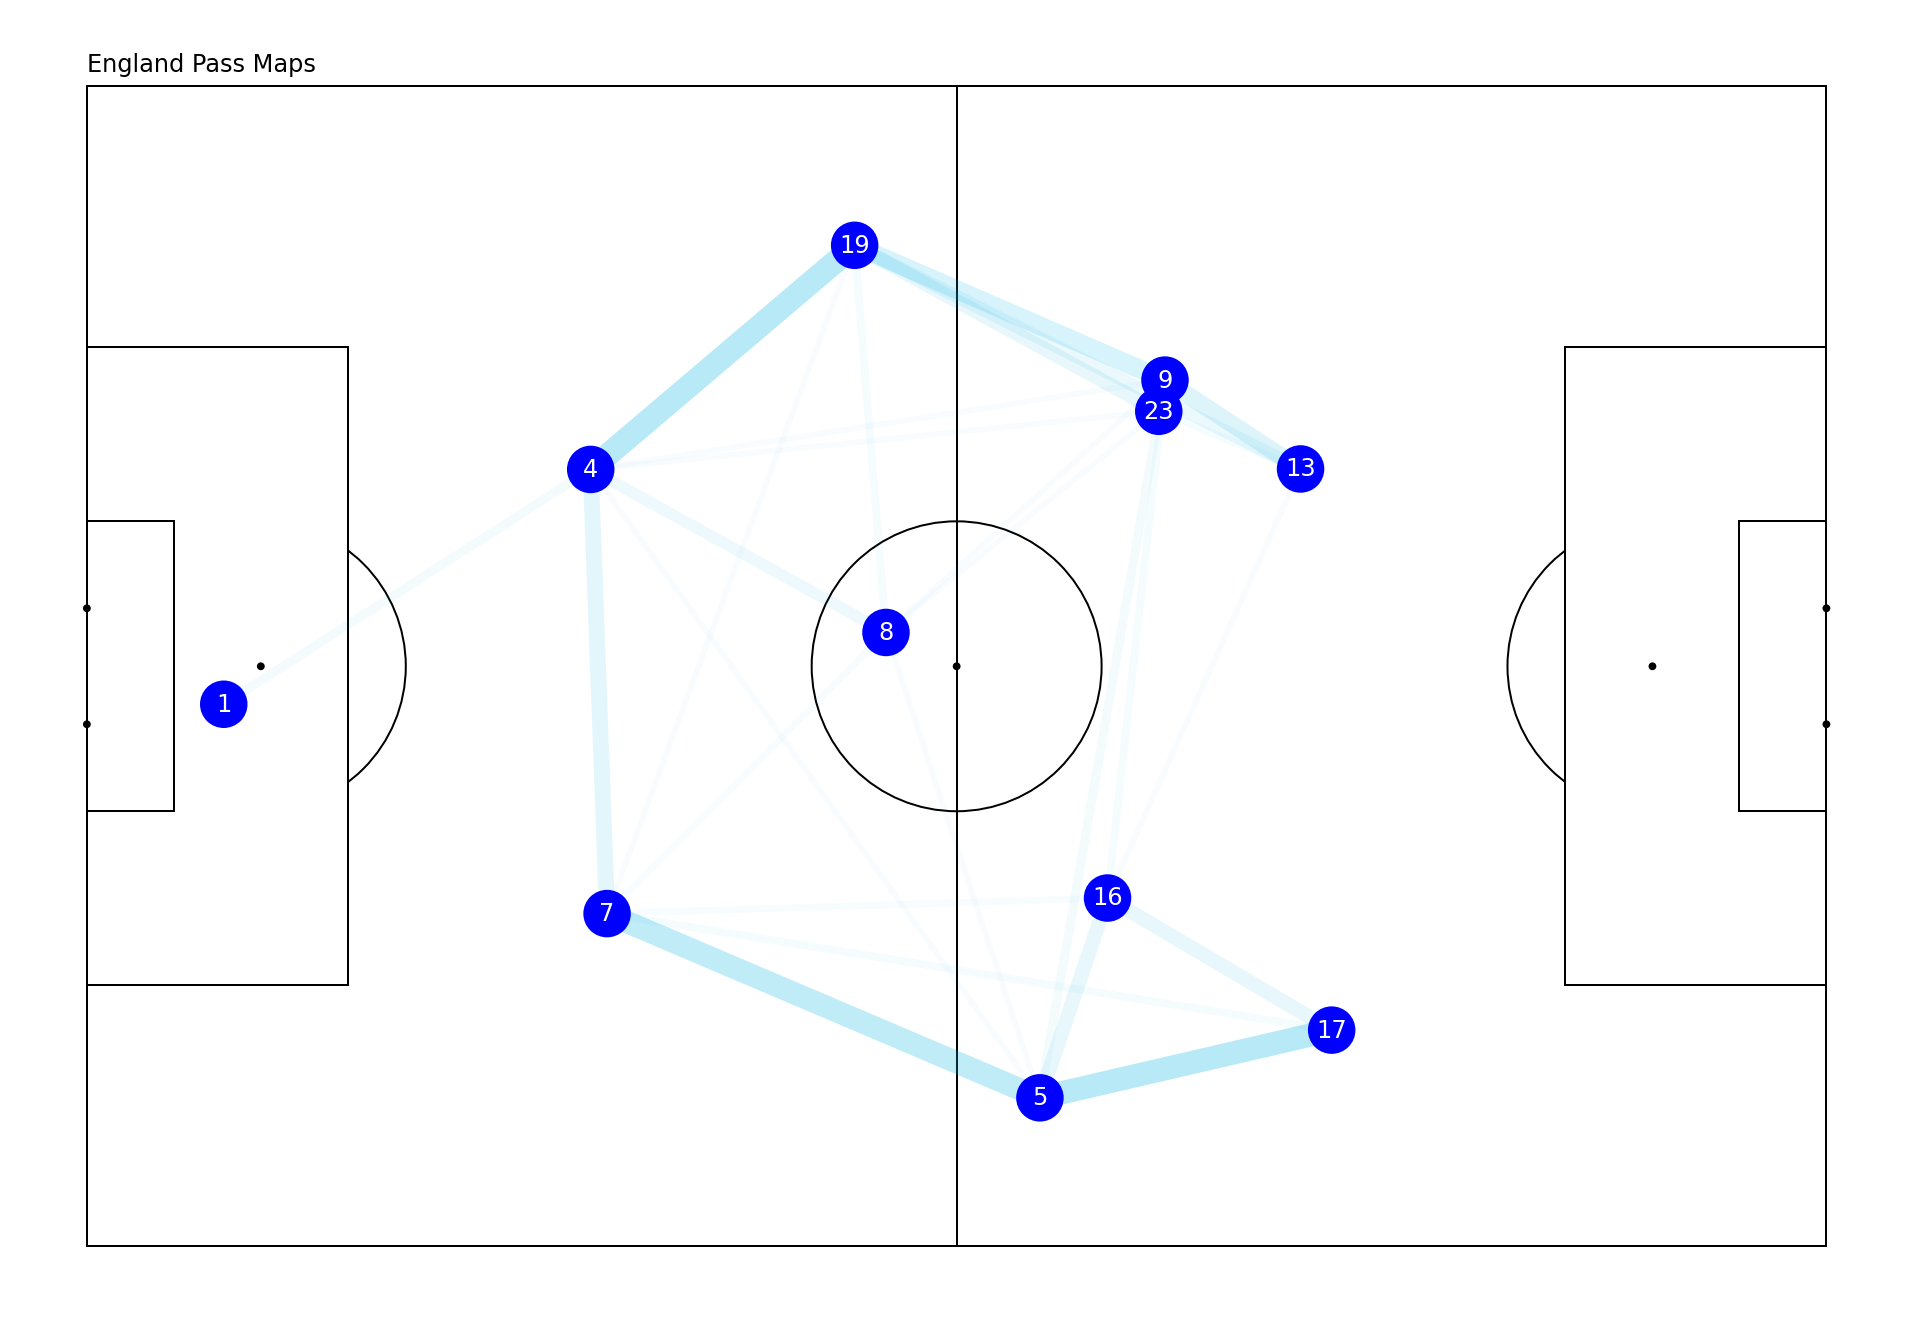

In [ ]:
# Plot Pass Network
fig, ax = plt.subplots(figsize=(20, 12))
ax.set_aspect(1)
pitch = pitch_pass(title="England Pass Maps")
pitch.create_pitch(ax)

fill_adj = lambda x: 0.8 / (1 + np.exp(-(x-20)*0.2))
weight_adj = lambda x: 2 / (1 + np.exp(-(x-10)*0.2))

for i, e in enumerate(lines):
    
    cosmetics = {
        'width': weight_adj(weights[i]),
        'head_width': 0,
        'head_length': 0,
        'facecolor': (0, 0.7, 0.9, fill_adj(weights[i])),
        'edgecolor': (0, 0, 0, 0)
    }
    if weights[i] > 2:
        pitch.draw_lines(ax, [e], cosmetics=cosmetics)


cosmetics = {
    'linewidth': 2,
    'facecolor': (0, 0, 1, 1),
    'edgecolor': (0, 0, 1, 1),
    'radius': 1.5
}
pitch.draw_points(ax, [xy for k, xy in avg_positions.items()], cosmetics=cosmetics)

for k, v in avg_positions.items():
    jersey = starters[k]['jersey']
    x,y = v
    
    ax.text(pitch.x_adj(x), pitch.y_adj(y),
            jersey, fontsize=12,
            ha='center', va='center',
            color='white')


plt.ylim(pitch.ylim)
plt.xlim(pitch.xlim)
plt.axis('off')
plt.show()

Investigating our passing network we can again see an obvious pattern to play the ball to the wings indicated by the thicker edges in the network. And the relatively spares connections to the No.8 player. \\

We can conclude that in this game England appeared to be playing a style that focused on playing balls out to the wings and ultimate trying to dribble the ball into the box... 

## Learning Task

Use some of the techniques we have covered in this notebook and other approaches within the research to continue to investigate Englands playing style and make some inference on why they lost 2-0. 

## References

[Soccer Analytics Handbook](https://github.com/devinpleuler/analytics-handbook)

[Pass clustering with Python](https://github.com/devinpleuler/analytics-handbook)

[mplsoccer](https://mplsoccer.readthedocs.io/en/latest/index.html)